In [1]:
!pip install torch torchvision matplotlib tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Hyperparameters
image_size = 64
batch_size = 128
lr = 0.0002
beta1 = 0.5
nz = 100  # Latent vector size
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Download CIFAR-10 as an example dataset
dataset = datasets.CIFAR10(root="data", download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 170M/170M [00:05<00:00, 31.2MB/s]


Extracting data/cifar-10-python.tar.gz to data


In [17]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0),  # Output: 512x4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # Output: 256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # Output: 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # Output: 64x32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),  # Output: 3x64x64
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [18]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # Input: 3x64x64, Output: 64x32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),  # Output: 128x16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),  # Output: 256x8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),  # Output: 512x4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0),  # Final output: 1x1x1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)  # Flatten to (batch_size,)


In [20]:
nz = 100  # Set the latent vector size (e.g., 100)
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


100%|██████████| 391/391 [01:23<00:00,  4.67it/s]


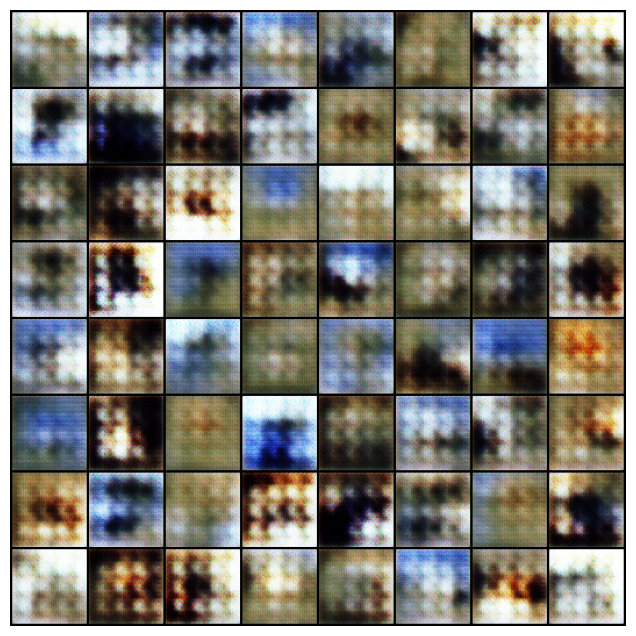

100%|██████████| 391/391 [01:22<00:00,  4.73it/s]


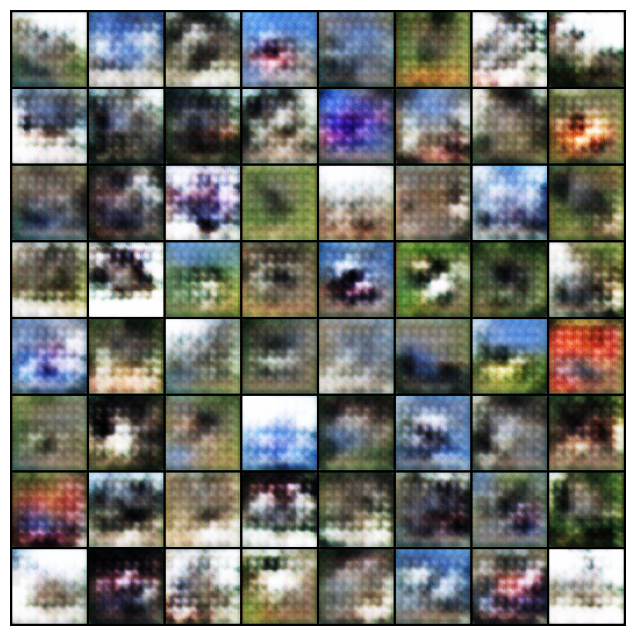

100%|██████████| 391/391 [01:22<00:00,  4.73it/s]


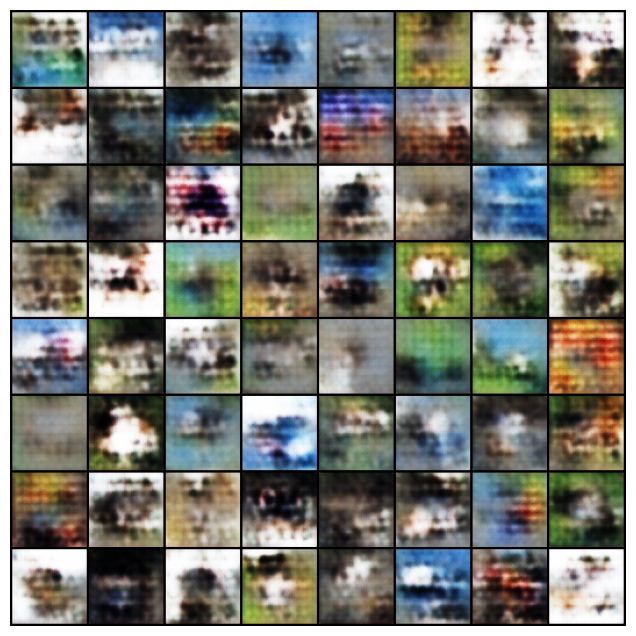

100%|██████████| 391/391 [01:22<00:00,  4.75it/s]


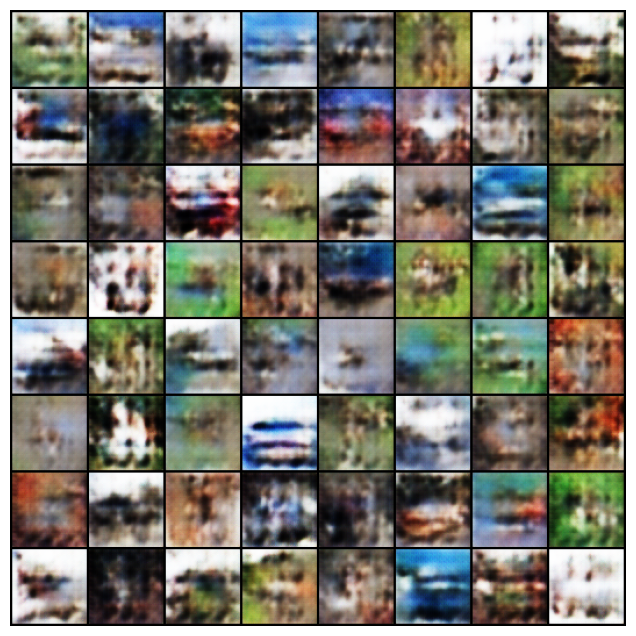

100%|██████████| 391/391 [01:22<00:00,  4.73it/s]


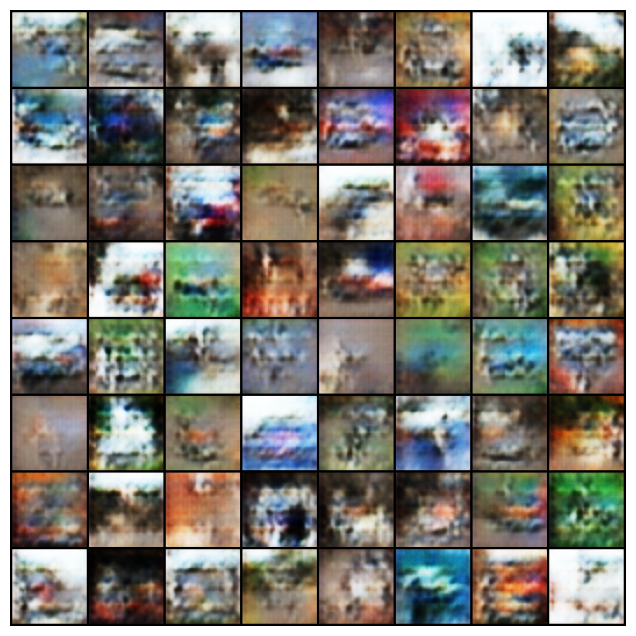

In [21]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.

for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(dataloader)):
        # Update Discriminator
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_images).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    # Generate images for visualization
    if epoch % 1 == 0:
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
        plt.show()


In [22]:
torch.save(netG.state_dict(), "generator.pth")
torch.save(netD.state_dict(), "discriminator.pth")


<ipython-input-23-08d584031958>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load("generator.pth"))


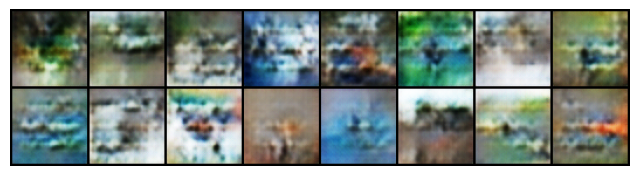

In [23]:
# Load the generator model
netG.load_state_dict(torch.load("generator.pth"))
netG.eval()

# Generate new images
noise = torch.randn(16, nz, 1, 1, device=device)
with torch.no_grad():
    generated_images = netG(noise).detach().cpu()

# Display the generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()
